In [1]:
import os 
import numpy as np 
import pickle
from matplotlib import pyplot as plt
import matplotlib
import shutil
# import seaborn as sns
# from traj_run import rho_ohmic
from typing import Any
from numpy import dtype, ndarray
import scipy
from scipy.optimize import curve_fit
from scipy.fft import fft, fftfreq
from scipy.interpolate import interp1d
import pywt
from data_analysis import read_line, read_exp, read_omega, get_rho_array, translate_param, chunk_data, interp_dat, do_fft, \
    fft_analysis, func_gentor, draw_t_S, draw_w_S, wavelet_denoising, line_monotonic_detect, show_result_t_S, \
    show_fft_res, show_w_freqs, show_w_freqs1, get_data_of_dof, get_signal_freq, do_cft, get_signal_amp, read_job_parameter

from scipy.optimize import curve_fit

2024-10-23 17:17:17,691[INFO] Use NumPy as backend
2024-10-23 17:17:17,691[INFO] numpy random seed is 9012
2024-10-23 17:17:17,692[INFO] random seed is 1092
2024-10-23 17:17:17,693[INFO] Git Commit Hash: d897b277e9ff95f70c482307f2a5078cb59cac6a
2024-10-23 17:17:17,694[INFO] use 64 bits


In [2]:

mother_folder = '/home/ansatz/data/comp/sbm/24_09_28'
nsteps = 500

In [3]:
vn_entropy_1site_all_lines ={}
# for line in sorted([ s for s in os.listdir(mother_folder) if s.startswith('traj_s') ]):
#     points = { i_step : f"_{i_step}_step_entropy_1sites.pickle" for i_step in range(100) }
#     nmodes = int(os.path.basename(line).split('_nmodes')[1].split('_')[0])

#     rho_type = 0 if 'rho_type' not in os.path.basename(line) else int(os.path.basename(line).split('rho_type_')[1])    
#     key = f"{line.split('_')[1]}-{line.split('_')[2]}-nmodes{nmodes}-rho{rho_type}"
#     print(key)
#     vn_entropy_1site_all_lines[key] = points
print('-----')
for line in sorted([ s for s in os.listdir(mother_folder) if s.startswith('traj_s') ]):
    s, alpha, Omega, omega_c, nmodes, bond_dims, td_method, rho_type = read_job_parameter(line)
    points = { i_step : f'{i_step:04}_step_entropy_1site.pickle' for i_step in range(nsteps) }

    key = line
    # print(key)
    vn_entropy_1site_all_lines[key] = points

-----


In [4]:
for key in vn_entropy_1site_all_lines.keys():
    print(key)

traj_s0.10_alpha0.01_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0
traj_s0.10_alpha0.05_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0
traj_s0.10_alpha0.10_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0
traj_s0.10_alpha0.15_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0
traj_s0.10_alpha0.20_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0
traj_s0.30_alpha0.80_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0
traj_s0.40_alpha0.05_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0
traj_s0.40_alpha0.10_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0
traj_s0.40_alpha0.20_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0
traj_s0.40_alpha0.25_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0
traj_s0.40_alpha0.30_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho_type_0
traj_s0.40_alpha0.80_Omega1_omega_c10_nmodes1000_bond_dims20_td_method_0_rho

In [5]:
def get_freq_cft_xf_yf(mother_folder=mother_folder, data_dict=vn_entropy_1site_all_lines,\
                  s=0.7, alpha=0.4, nmodes=1000, rho_type=0, nsteps=100,
                  idof=504):
    v_dof = data = get_data_of_dof(mother_folder=mother_folder, data_dict=vn_entropy_1site_all_lines,\
                  s=s, alpha=alpha, nmodes=nmodes, rho_type=rho_type, nsteps=nsteps,
                  idof=idof)
    signal = wavelet_denoising(v_dof)
    N = 1001
    xf, yf = do_cft(np.linspace(0, 10, 100), signal, N)

    plt.clf()

    
    amp = 2.0/N * np.abs(yf)

    plt.title(f's_{s}-alpha_{alpha}-nmodes_{nmodes}-rho_type_{rho_type}-nsteps_{nsteps}')
    plt.plot(xf, amp, label=f'v_{idof}')
    indexs , _ = scipy.signal.find_peaks(amp)
    
    if len(indexs) != 0 : 
        peaks = [ amp[index] for index in indexs ]
        freqs = [ xf[index] for index in indexs ]
        with open(f'data/s{s}-alpha{alpha}-idof_{idof:03}_cft_peaks.pickle', 'wb') as f:
            pickle.dump([freqs, peaks], f)
        # index = indexs[peaks.index(max(peaks))]
        # index = indexs[0]
        # print(peaks.index(max(peaks)), index)
        # index = indexs[0]
        # freq =  xf[index]
        # amplitude = amp[index]
        # amplitude = 2.0/N * np.abs(yf[index])
        # phase = np.angle(np.abs(yf[index]))
        # print(freq, amplitude)
        sorted_peaks = sorted(peaks, reverse=True)
        index = indexs[peaks.index(sorted_peaks[0])]
        freq =  xf[index]
        amplitude = amp[index]
        plt.scatter(freq, amplitude, color='red')
        plt.annotate(text=f'{xf[index]}_{amp[index]}', xy=(xf[index], amp[index]), xytext=(xf[index], amp[index]))
        if len(indexs) >= 1:
            index = indexs[peaks.index(sorted_peaks[1])]
            freq =  xf[index]
            amplitude = amp[index]
            plt.scatter(freq, amplitude, color='red')
            plt.annotate(text=f'{xf[index]}_{amp[index]}', xy=(xf[index], amp[index]), xytext=(xf[index], amp[index]))

        if len(indexs) >= 2:
            index = indexs[peaks.index(sorted_peaks[2])]
            freq =  xf[index]
            amplitude = amp[index]
            plt.scatter(freq, amplitude, color='red')
            plt.annotate(text=f'{xf[index]}_{amp[index]}', xy=(xf[index], amp[index]), xytext=(xf[index], amp[index]))
        plt.legend()
        plt.savefig(f'data/s{s}-alpha{alpha}-idof_{idof:03}_cft_peaks.png')
        # plt.clf()
        return freq
    else:
        return 0


def r_squared(x,y, param_list, func):
    mean = np.mean(y)  # 1.y mean

    ss_tot = np.sum((y - mean) ** 2)  # 2.total sum of squares

    ss_res = np.sum((y - func(x, *param_list)) ** 2)  # 3.residual sum of squares

    r_squared = 1 - (ss_res / ss_tot)
    return r_squared

In [6]:
ids = [ i for i in range(1000) if (i+1)%5==0 and i > 98 and i < 630]


In [7]:
s=0.5
alpha=0.80
nmodes=1000
rho_type=0
nstep=500   

job_name = f"traj_s{s:.2f}_alpha{alpha:.2f}_Omega{Omega}_omega_c{omega_c}_nmodes{nmodes}_bond_dims{bond_dims}_td_method_{td_method}_rho_type_{rho_type}"
pf = os.path.join(mother_folder, f'traj_s{s:.02f}_alpha{alpha:.02f}_Omega1_omega_c10_nmodes{nmodes}_bond_dims20_td_method_0_rho_type_{rho_type}')

key =job_name

omgeas_eff, rho_array_eff, modes_eff, dats = chunk_data(pf, vn_entropy_1site_all_lines, key, nstep=nstep)

In [8]:
dats.__len__()

500

In [9]:
dats = [ get_signal_amp(mother_folder=mother_folder, data_dict=vn_entropy_1site_all_lines, s=s, alpha=alpha, nmodes=nmodes, rho_type=rho_type, nsteps=nsteps, imode=i, plot=False) for i in range(1000) if (i+1)%5==0 and i > 98 and i < 630 ]

0.13577978372865615
2.0055203803729107 -0.968837666053275 0.02478270021854707


Text(0.0, -0.0, 'y = 2.006 * np.exp(-0.969* x) + 0.024783, R**2: 0.995')

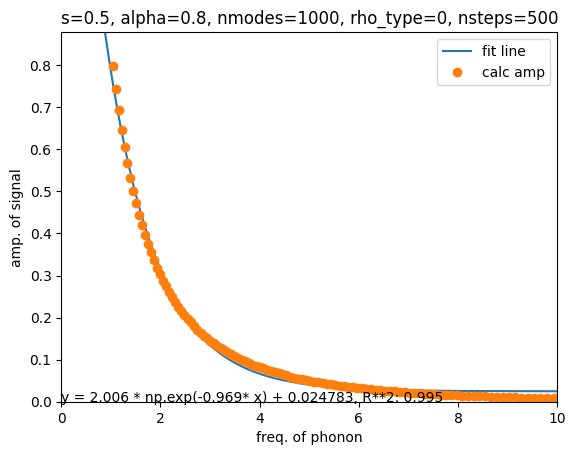

In [10]:
# plt.plot([ _[0] for _ in dats ],[ _[1] for _ in dats ], label ='amp' )

    
# plt.xlabel('freq of ph')
# plt.ylim(0, max([ _[1] for _ in dats ])+ 0.1* max([ _[1] for _ in dats ]))
# plt.ylabel('amp of signal')
# plt.title(f's={s}, alpha={alpha}, nmodes={nmodes}, rho_type={0}, nsteps={nsteps}')
# plt.legend()
# plt.text(x=0.1, y=0.1, s=f'y = {params.x[0]:03f} * x + {params.x[1]:03f}, R**2: {r_2:.3f}')

a = 0.4
b = -1
c = 0.1
y_true = np.array([ _[1] for _ in dats ])
x = np.array([ _[0] for _ in dats ])

def amp_func(x, a, b, c):
    y = a * np.exp(b* x) + c
    return y


def loss(params):
    a, b, c= params
    y_pred = amp_func(x, a, b, c)
    return np.linalg.norm(y_pred - y_true)



params = scipy.optimize.minimize(loss, [a, b, c])
print(params.fun)
a = params.x[0]
b = params.x[1]
c = params.x[2]
r_2 = r_squared(x, y_true, [a, b, c], amp_func)
print(a, b , c)


func_x = np.linspace(0, 10, 500)
func_y = amp_func(func_x, params.x[0], params.x[1], params.x[2])
plt.plot(func_x, func_y , label='fit line')
plt.plot([ _[0] for _ in dats ], [ _[1] for _ in dats ],'o', label='calc amp')
plt.xlim(0, 10)
plt.xlabel('freq. of phonon')




plt.ylim(0, max([ _[1] for _ in dats ])+ 0.1* max([ _[1] for _ in dats ]))
plt.ylabel('amp. of signal')
plt.title(f's={s}, alpha={alpha}, nmodes={nmodes}, rho_type={0}, nsteps={nsteps}')
plt.legend()
plt.text(x=0.0, y=-0.0, s=f'y = {params.x[0]:.3f} * np.exp({params.x[1]:.3f}* x) + {params.x[2]:3f}, R**2: {r_2:.3f}')


In [11]:
dats = [get_signal_freq(mother_folder=mother_folder, data_dict=vn_entropy_1site_all_lines, s=s, alpha=alpha, nmodes=nmodes, rho_type=rho_type, nsteps=nsteps, imode=i, plot=False) for i in range(1000) if (i+1)%5==0 and i > 98 and i < 630]

In [12]:
a = 0.4
b = -0.1

y_true = np.array([ _[1] for _ in dats ])
x = np.array([ _[0] for _ in dats ])

def amp_func(x, a, b, c):
    y = a * np.exp(b* x) + c
    return y


def loss(params):
    a, b, c= params
    y_pred = amp_func(x, a, b, c)
    return np.linalg.norm(y_pred - y_true)



params = scipy.optimize.minimize(loss, [a, b, c])
print(params.fun)
a = params.x[0]
b = params.x[1]
c = params.x[2]

0.008062742759839897


In [13]:


y_true = np.array([ _[1] for _ in dats ])
x = np.array([ _[0] for _ in dats ])

def freq_func(x, a, b):
    y = a * x + b 
    return y


def loss(params):
    a, b= params
    y_pred = freq_func(x, a, b)
    return np.linalg.norm(y_pred - y_true)



params = scipy.optimize.minimize(loss, [a, b])
print(params.fun)
a = params.x[0]
b = params.x[1]
r_2 = r_squared(x, y_true, [a, b], freq_func)

0.0009249315308978661


Text(0.1, 0.1, 'y = 0.158911 * x + -0.000183, R**2: 1.000')

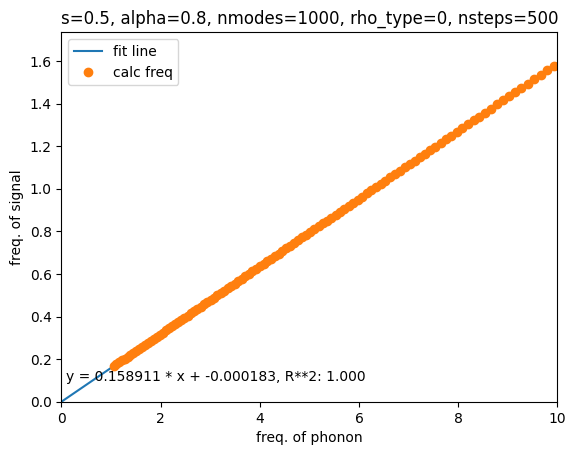

In [14]:
func_x = np.linspace(0, 10, 500)
func_y = params.x[0] * func_x + params.x[1]
plt.plot(func_x, func_y , label='fit line')
plt.plot([ _[0] for _ in dats ], [ _[1] for _ in dats ],'o', label='calc freq')
plt.xlim(0, 10)
plt.xlabel('freq. of phonon')
plt.ylim(0, max([ _[1] for _ in dats ])+ 0.1* max([ _[1] for _ in dats ]))
plt.ylabel('freq. of signal')
plt.title(f's={s}, alpha={alpha}, nmodes={nmodes}, rho_type={0}, nsteps={nsteps}')
plt.legend()
plt.text(x=0.1, y=0.1, s=f'y = {params.x[0]:3f} * x + {params.x[1]:3f}, R**2: {r_2:.3f}')

In [15]:
draw_ids = []
for i in range(11):
    draw_ids.append(ids[i*10])
draw_ids

[99, 149, 199, 249, 299, 349, 399, 449, 499, 549, 599]

In [16]:
mother_folder

'/home/ansatz/data/comp/sbm/24_09_28'

(0.0, 50.0)

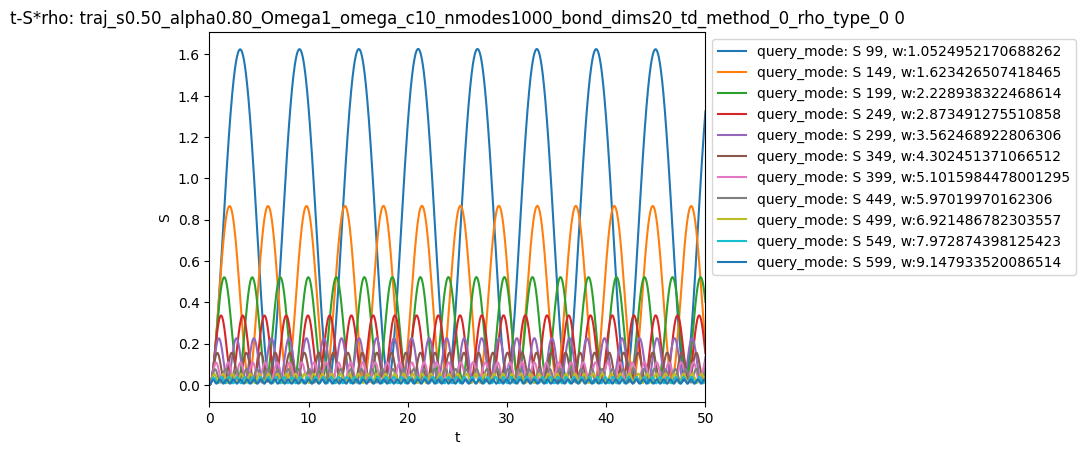

In [17]:
# draw_t_S(pf, vn_entropy_1site_all_lines, key, query_mode=99, nstep=500)
# draw_t_S(pf, vn_entropy_1site_all_lines, key, query_mode=99, nstep=500)
show_result_t_S(mother_folder, vn_entropy_1site_all_lines, s, alpha, query_modes=draw_ids, nstep=500)
plt.xlim(0, 50)

In [18]:
params

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 0.0009249315308978661
        x: [ 1.589e-01 -1.831e-04]
      nit: 20
      jac: [-7.034e-03 -3.606e-03]
 hess_inv: [[ 1.479e-06 -6.791e-06]
            [-6.791e-06  4.078e-05]]
     nfev: 317
     njev: 102

In [19]:
x

array([1.05249522, 1.10814366, 1.16410352, 1.22037829, 1.27697153,
       1.33388688, 1.39112802, 1.44869871, 1.50660275, 1.56484403,
       1.62342651, 1.6823542 , 1.74163119, 1.80126166, 1.86124984,
       1.92160006, 1.9823167 , 2.04340424, 2.10486725, 2.16671037,
       2.22893832, 2.29155593, 2.35456812, 2.41797987, 2.48179629,
       2.54602259, 2.61066406, 2.6757261 , 2.74121421, 2.80713403,
       2.87349128, 2.94029179, 3.00754154, 3.07524661, 3.1434132 ,
       3.21204764, 3.28115642, 3.35074612, 3.4208235 , 3.49139542,
       3.56246892, 3.63405119, 3.70614956, 3.77877152, 3.85192473,
       3.92561703, 3.99985642, 4.07465109, 4.15000939, 4.2259399 ,
       4.30245137, 4.37955276, 4.45725322, 4.53556216, 4.61448917,
       4.69404408, 4.77423697, 4.85507816, 4.9365782 , 5.01874793,
       5.10159845, 5.18514112, 5.26938762, 5.3543499 , 5.44004022,
       5.52647119, 5.6136557 , 5.70160701, 5.79033874, 5.87986485,
       5.9701997 , 6.06135804, 6.153355  , 6.24620618, 6.33992

# not need anymore 

In [20]:
# 

In [21]:
dats = [get_signal_freq(mother_folder=mother_folder, data_dict=vn_entropy_1site_all_lines, s=0.7, alpha=0.8, nmodes=1000, rho_type=0, nsteps=100, imode=i, plot=False) for i in range(1000) if (i+1)%5==0 and i > 98 and i < 630]

(0.0, 10.0)

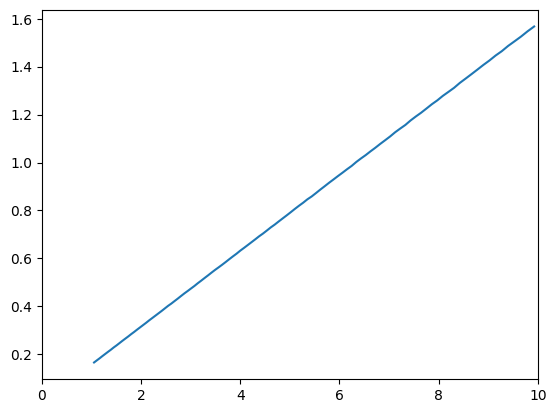

In [22]:
plt.plot([ _[0] for _ in dats ], [ _[1] for _ in dats ])
plt.xlim(0, 10)

In [23]:
dats = [get_signal_freq(mother_folder=mother_folder, data_dict=vn_entropy_1site_all_lines, s=0.7, alpha=0.05, nmodes=1000, rho_type=0, nsteps=200, imode=i, plot=False) for i in range(1000) if (i+1)%5==0 and i > 98 and i < 630]

(0.0, 10.0)

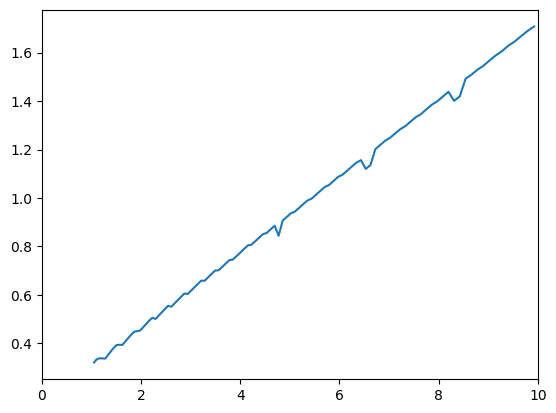

In [24]:
plt.plot([ _[0] for _ in dats ], [ _[1] for _ in dats ])
plt.xlim(0, 10)